# Smartphone Battery Life Predictor
An ML model for prediction how much time a phone battery has left before it is depleted.

By: Mats van Liempd

Version: 2.0.0

In [61]:
import sklearn as skl
import numpy as np
import matplotlib as mpl
import seaborn as sb
import pandas as pd

#### Importing The Dataset

In [62]:
data = pd.read_csv("datasets/Data Collection Smartphone Battery Life(Sheet1)_with_capacity_with_estimated_life.csv")
data.head()
data.sort_values(by="sessionlength", ascending=False)

,Id,userage,usergender,userphone,phoneos,batteryhealth,startbatterypercentage,endbatterypercentage,sessionlength,timedonphone,appcount,screenbrightness,usednetwork,usedbluetooth,usedGPS,usedbatterysaving,batterycapacity_mAh,estimated_remaining_life_s
11,12,26,Man,iPhone 16 Pro Max,iOs,100,100,71,18034,No,4,100.0,Yes,No,No,No,4685,62186
12,13,24,Man,iPhone 16,iOs,100,100,64,18034,No,4,100.0,Yes,No,No,No,3561,50094
10,11,25,Man,iPhone 17,iOs,100,100,64,18034,No,4,100.0,Yes,No,No,No,3692,50094
9,10,25,Man,iPhone Air,iOs,100,100,51,18034,No,4,100.0,Yes,No,No,No,3149,36804
8,9,26,Man,iPhone 17 Pro,iOs,100,100,66,18034,No,4,100.0,Yes,No,No,No,4252,53041
7,8,26,Man,iPhone 17 Pro Max,iOs,100,100,73,18034,No,4,100.0,Yes,No,No,No,5088,66793
13,14,25,Man,Samsung Galaxy S25 Ultra,Android,100,100,69,18034,No,4,100.0,Yes,No,No,No,5000,58174
15,16,24,Prefer not to say,Samsung Z Flip 7,Android,100,100,73,18000,No,5,100.0,Yes,No,No,No,4300,66667
16,17,24,Prefer not to say,Samsung Galaxy S25 Ultra,Android,100,100,73,18000,No,5,100.0,Yes,No,No,No,5000,66667
14,15,23,Prefer not to say,Samsung Z Fold 7,Android,100,100,66,18000,No,5,100.0,Yes,No,No,No,4400,52941


#### Data Cleaning
Making the data usable with actual models

In [63]:
df = pd.DataFrame(data)
df = df.drop(columns=["Id"])

# change phoneos to 0 (iOs) and 1 (Android) 
df["phoneos"] = df["phoneos"].str.strip().str.lower().map({
    "ios": 0,
    "android": 1
})

# change all yes/no collumns in the data set to 1/0 booleans
yes_no_cols = [
    col for col in df.columns
    if df[col].astype(str).str.lower().isin(["yes", "no"]).any() and col != "phoneos"
]

for col in yes_no_cols:
    df[col] = df[col].astype(str).str.strip().str.lower().map({
        "yes": 1,
        "no": 0
    })

# converting gender options to numerical values
df["usergender"] = df["usergender"].str.strip().str.lower().map({
    "man": 0,
    "woman": 1,
    "non-binary": 2,
    "prefer not to say": 3
})

df.sample(5)

,userage,usergender,userphone,phoneos,batteryhealth,startbatterypercentage,endbatterypercentage,sessionlength,timedonphone,appcount,screenbrightness,usednetwork,usedbluetooth,usedGPS,usedbatterysaving,batterycapacity_mAh,estimated_remaining_life_s
6,20,0,iPhone 12,0,97,100,93,1508,1,8,5.0,1,0,0,0,2815,21543
4,27,0,Iphone 12,0,79,52,32,1500,1,3,35.0,1,0,0,0,2815,3900
19,20,0,ROG Phone 8 Pro Edition,1,95,70,59,2194,0,1,40.0,1,0,0,1,5500,13962
5,26,1,Samsung Galaxy S24 Ultra,1,95,80,78,956,0,1,10.0,1,1,0,0,5000,38240
11,26,0,iPhone 16 Pro Max,0,100,100,71,18034,0,4,100.0,1,0,0,0,4685,62186


#### Feature Selection

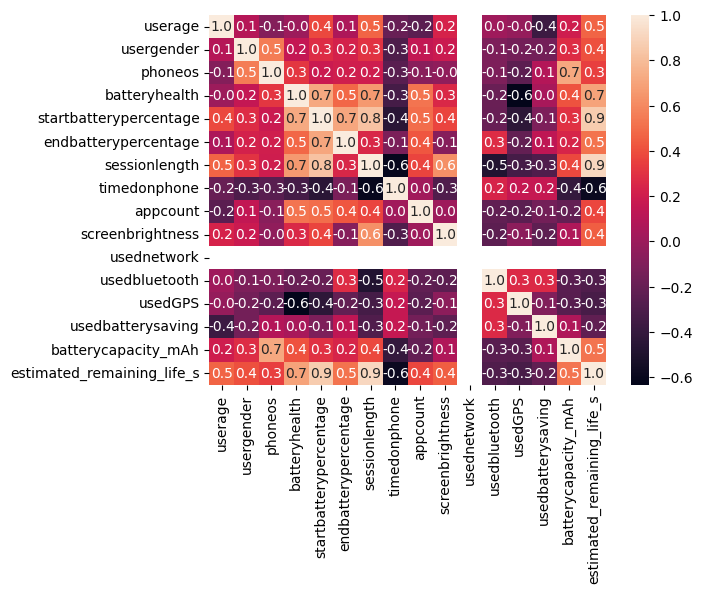

In [64]:
# correlations = df.corr()
correlations = df.select_dtypes(include='number').corr()
plot = sb.heatmap(correlations, cbar=True, annot=True, fmt=".1f")

a lot of possibly usefull features spotted, im happy

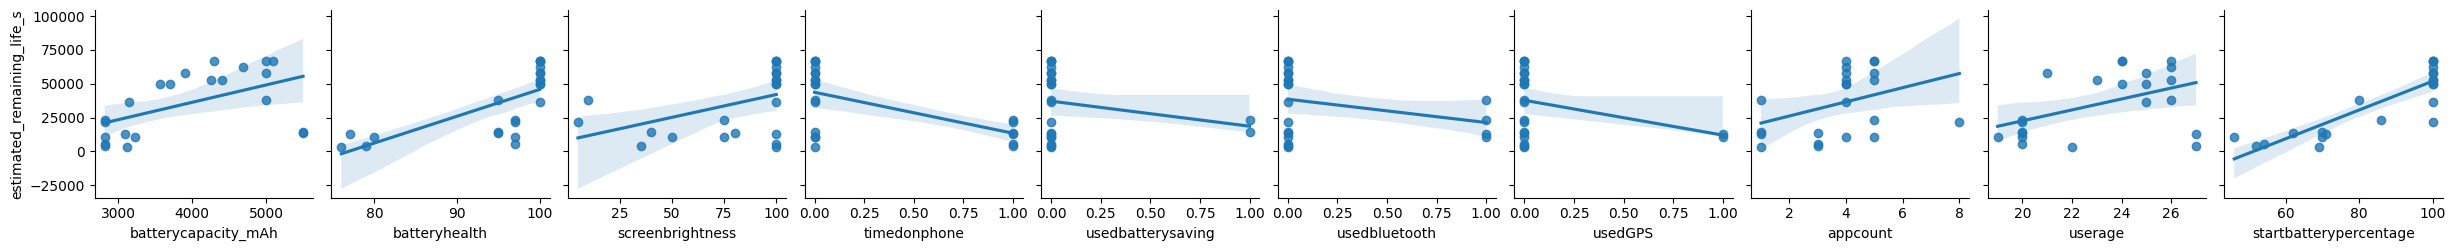

In [65]:
candidates = ["batterycapacity_mAh", "batteryhealth", "screenbrightness", "timedonphone", "usedbatterysaving", "usedbluetooth", "usedGPS", "appcount", "userage", "startbatterypercentage"]
plot = sb.pairplot(df, x_vars=candidates, y_vars="estimated_remaining_life_s", kind="reg")

i can forsee a possible problem as not all of the data looks as linear as i thought i would look

#### Splitting The Data

In [66]:
from sklearn.model_selection import train_test_split
features = ["batterycapacity_mAh", "batteryhealth", "screenbrightness", "timedonphone", "usedbatterysaving", "usedbluetooth", "usedGPS", "appcount", "userage", "startbatterypercentage"]
target = "estimated_remaining_life_s"
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 22 observations, of which 17 are now in the train set, and 5 in the test set.


#### Training The Model (Linear Regression)

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
model = LinearRegression()
result = model.fit(X_train, y_train)
score = model.score(X_test, y_test)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print("R²:", score)
print(f"MAE: {int(mae // 3600)}h {int((mae % 3600) // 60)}m {int(mae % 60)}s ({mae})")

R²: -126.81328341084654
MAE: 53h 59m 51s (194391.19601024123)


linear is NOT working ;-; -> conclusion: data is not linear

### Testing other possible models

#### Random Forest Regressor

In [68]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Accuracy:", score)
print(f"MAE: {int(mae // 3600)}h {int((mae % 3600) // 60)}m {int(mae % 60)}s ({mae})")

Accuracy: 0.8210323646433713
MAE: 2h 37m 9s (9429.706)


this is definitely an improvement over the linear model, but 2 and a half hours off is still a lot and not at all what I want.

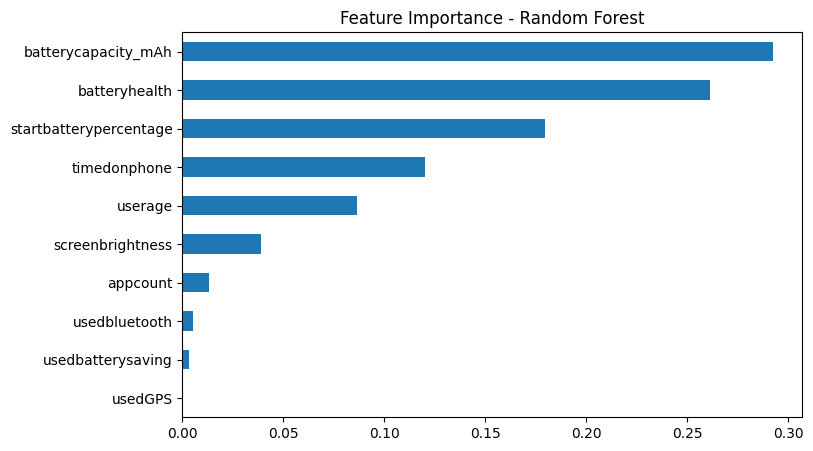

In [69]:
import matplotlib.pyplot as plt
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values()
importance.plot(kind="barh", figsize=(8,5), title="Feature Importance - Random Forest")
plt.show()

the feature importance seems quite logical and good :D

#### Gradient Boosting Regressor

In [70]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=42)
# model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, random_state=42) # -> weaker results
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("R²:", score)
print(f"MAE: {int(mae // 3600)}h {int((mae % 3600) // 60)}m {int(mae % 60)}s ({mae})")

R²: 0.946546256219869
MAE: 1h 23m 57s (5037.401249713812)


Very good results compared to the other 2 models so ill be going with this one :)

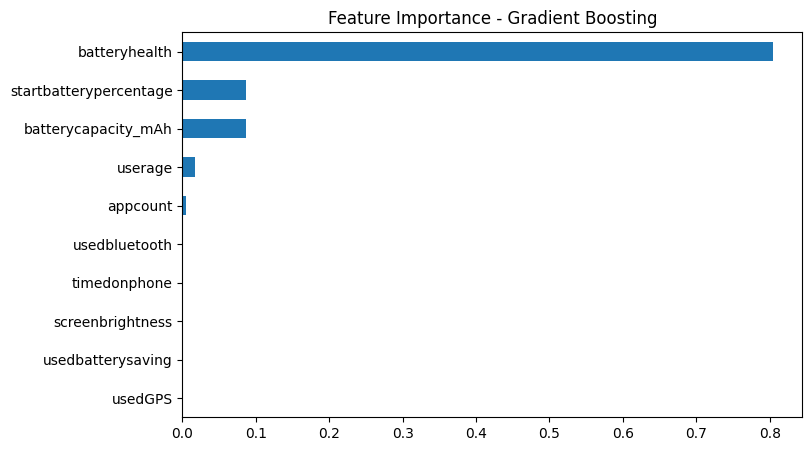

In [71]:
import matplotlib.pyplot as plt
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values()
importance.plot(kind="barh", figsize=(8,5), title="Feature Importance - Gradient Boosting")
plt.show()

the feature importance seems incredibly skewed.

### Conclusion Iteration 0
From now on I will be using the Gradient Boosting Regressor as it is already yielding the highest results. I also will need way more data for the Mean Absolute Error to go down and actually yield results that can be used, since results that are 1 hour+ off of the actual battery life is just not acceptable. The good thing is that the R² is really close to 1, which means the model is performing well and this is why I assume I need more data for it to properly function.